# Setup

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import datetime
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
from keras import layers
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, AveragePooling2D, BatchNormalization, Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Preparation

In [ ]:
# Environment variable

main_img_dir =  '/content/drive/MyDrive/BME DESIGN/BrEaST-Lesions_USG-images_and_masks'
preprocessed_data_dir = '/content/drive/MyDrive/BME DESIGN/preprocessed_data_2_classes'
train_dir = preprocessed_data_dir + '/train'
test_dir = preprocessed_data_dir + '/test'
val_dir = preprocessed_data_dir + '/val'
train_label = preprocessed_data_dir + '/train_label.csv'
val_label = preprocessed_data_dir + '/val_label.csv'
test_label = preprocessed_data_dir + '/test_label.csv'
model_path = '/content/drive/MyDrive/BME DESIGN/MobileNetV2_2_classes_full_metadata.keras'

In [ ]:
target_size = (224, 224) # vậy đây là đầu vào của model ?
def Get_data(df_path, img_path, _target_size):
    img_list = []
    classification = []
    age = []
    shape = []
    echogenicity = []
    posterior_features = []
    halo = []
    calcifications =[]
    skin_thickening	= []

    df = pd.read_csv(df_path)
    for index, row in df.iterrows():
        img_list.append(cv2.imread(img_path + '/' + row['Image_filename']  )) #Đọc hình ảnh từ thư mục img_path dựa trên image_id và thêm vào danh sách img_list.
        classification.append(row['Classification'])
        age.append(float(row['Age']))
        shape.append(row['Shape'])
        echogenicity.append(row['Echogenicity'])
        posterior_features.append(row['Posterior_features'])
        halo.append(row['Halo'])
        calcifications.append(row['Calcifications'])
        skin_thickening.append(row['Skin_thickening'])
    for x in range(len(img_list)):
        img_list[x] = tf.keras.preprocessing.image.smart_resize(img_list[x], _target_size) #Thay đổi kích thước từng hình ảnh trong img_list về kích thước mục tiêu _target_size.
        img_list[x] = tf.keras.applications.efficientnet.preprocess_input(img_list[x])
    le = preprocessing.LabelEncoder() #mã hóa nhãn từ các chuỗi sang số nguyên
    le.fit(classification)
    classification = le.transform(classification)
    classification = tf.keras.utils.to_categorical(classification)
    return (img_list, age, shape, echogenicity, posterior_features, halo, calcifications, skin_thickening), classification

## Training Data

In [ ]:
train_df = pd.read_csv(train_label)

In [ ]:
(train_img_lst, train_age, train_shape, train_echogenicity, train_posterior_features, train_halo, train_calcifications, train_skin_thickening), labels = Get_data(train_label, main_img_dir, target_size)

In [ ]:
print("Number of images: {}".format(len(train_img_lst)))

Number of images: 203


## Validation Data

In [ ]:
val_df = pd.read_csv(val_label)

In [ ]:
(val_img_lst, val_age, val_shape, val_echogenicity, val_posterior_features, val_halo, val_calcifications, val_skin_thickening), val_labels = Get_data(val_label, main_img_dir, target_size)

In [ ]:
(test_img_lst, test_age, test_shape, test_echogenicity, test_posterior_features, test_halo, test_calcifications, test_skin_thickening), test_labels = Get_data(test_label, main_img_dir, target_size)

# Model

## Input Block

In [ ]:
age_input = tf.keras.Input(shape=(1,), name='age', dtype=tf.float32) #float32 sử dụng 32 bit để biểu diễn mỗi số thực
shape_input = tf.keras.Input(shape=(1,), name='shape', dtype=tf.string)
echogenicity_input = tf.keras.Input(shape=(1,), name='echogenicity', dtype=tf.string)
posterior_features_input = tf.keras.Input(shape=(1,), name='posterior_features', dtype=tf.string)
halo_input = tf.keras.Input(shape=(1,), name='halo', dtype=tf.string)
calcifications_input = tf.keras.Input(shape=(1,), name='calcifications', dtype=tf.string)
skin_thickening_input = tf.keras.Input(shape=(1,), name='skin_thickening', dtype=tf.string)

inputs = {'age' : age_input,
         'shape' : shape_input,
         'echogenicity' : echogenicity_input,
         'posterior_features' : posterior_features_input,
         'halo' : halo_input,
         'calcifications' : calcifications_input,
         'skin_thickening' : skin_thickening_input,
         }
# age input
norm = layers.Normalization()
norm.adapt(np.array(train_df[['Age']]))
age_norm_input = norm(age_input)
# Shape input
shape_lookup = layers.StringLookup(vocabulary=np.unique(train_df['Shape']))
shape_one_hot = layers.CategoryEncoding(num_tokens=shape_lookup.vocabulary_size())

preprocessed_shape_input = shape_lookup(shape_input)
preprocessed_shape_input = shape_one_hot(preprocessed_shape_input)
# echogenicity input
echogenicity_lookup = layers.StringLookup(vocabulary=np.unique(train_df['Echogenicity']))
echogenicity_one_hot = layers.CategoryEncoding(num_tokens=echogenicity_lookup.vocabulary_size())

preprocess_echogenicity_input = echogenicity_lookup(echogenicity_input)
preprocess_echogenicity_input = echogenicity_one_hot(preprocess_echogenicity_input)
# Posterior_features input
posterior_features_lookup = layers.StringLookup(vocabulary=np.unique(train_df['Posterior_features']))
posterior_features_one_hot = layers.CategoryEncoding(num_tokens=posterior_features_lookup.vocabulary_size())

preprocess_posterior_features_input = posterior_features_lookup(posterior_features_input)
preprocess_posterior_features_input = posterior_features_one_hot(preprocess_posterior_features_input)
# Halo_features input
halo_lookup = layers.StringLookup(vocabulary=np.unique(train_df['Halo']))
halo_one_hot = layers.CategoryEncoding(num_tokens=halo_lookup.vocabulary_size())

preprocess_halo_input = halo_lookup(halo_input)
preprocess_halo_input = halo_one_hot(preprocess_halo_input)
# skin_thickening input
skin_thickening_lookup = layers.StringLookup(vocabulary=np.unique(train_df['Skin_thickening']))
skin_thickening_one_hot = layers.CategoryEncoding(num_tokens=skin_thickening_lookup.vocabulary_size())

preprocess_skin_thickening_input = skin_thickening_lookup(skin_thickening_input)
preprocess_skin_thickening_input = skin_thickening_one_hot(preprocess_skin_thickening_input)
# calcifications input
calcifications_lookup = layers.StringLookup(vocabulary=np.unique(train_df['Calcifications']))
calcifications_one_hot = layers.CategoryEncoding(num_tokens=calcifications_lookup.vocabulary_size())

preprocess_calcifications_input = calcifications_lookup(calcifications_input)
preprocess_calcifications_input = calcifications_one_hot(preprocess_calcifications_input)
preprocessed_inputs = [age_norm_input, preprocessed_shape_input, preprocess_posterior_features_input, preprocess_halo_input, preprocess_skin_thickening_input, preprocess_calcifications_input, preprocess_echogenicity_input]
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)



In [ ]:
preprocessed_inputs_cat

<KerasTensor: shape=(None, 28) dtype=float32 (created by layer 'concatenate')>

## Soft Attention

In [ ]:
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf

In [ ]:
class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x


        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC

        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]

        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape


        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))


        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1)
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)


        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))

            x_exp = K.expand_dims(x,axis=-2)

            u = kl.Multiply()([exp_softmax_alpha, x_exp])

            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u

        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape):
        return [self.out_features_shape, self.out_attention_maps_shape]


    def get_config(self):
        return super(SoftAttention,self).get_config()

## Base Model

In [ ]:
MobileNetV2 = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,

)

inputs['image'] = MobileNetV2.input

# Exclude the last 28 layers of the model.
MobileNetV2_output = MobileNetV2.layers[-28].output

14536120/14536120 [==============================] - 0s 0us/step


## Final Model

In [ ]:
attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(MobileNetV2_output.shape[-1]),name='soft_attention')(MobileNetV2_output)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
MobileNetV2_output=(MaxPooling2D(pool_size=(2, 2),padding="same")(MobileNetV2_output))

MobileNetV2_output = layers.Concatenate()([MobileNetV2_output, attention_layer])
MobileNetV2_output = Activation('relu')(MobileNetV2_output)
MobileNetV2_output = Dropout(0.5)(MobileNetV2_output)

In [ ]:
output = Flatten()(MobileNetV2_output)
preprocessed_inputs_cat = (layers.Dense(4096, activation = 'relu')(preprocessed_inputs_cat))
output = layers.Concatenate()([output, preprocessed_inputs_cat])
output = Dense(2, activation='softmax')(output)
model = Model(inputs=inputs, outputs=output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

## Training

In [ ]:
kkkk

NameError: name 'kkkk' is not defined

In [ ]:
feature_dict = {'age' : np.array(train_age),
                'shape' : np.array(train_shape),
                'echogenicity' : np.array(train_echogenicity),
                'posterior_features' : np.array(train_posterior_features),
                'halo' : np.array(train_halo),
                'calcifications' : np.array(train_calcifications),
                'skin_thickening' : np.array(train_skin_thickening),
                'image' : np.array(train_img_lst)
               }
val_dict = {'age' : np.array(val_age),
                'shape' : np.array(val_shape),
                'echogenicity' : np.array(val_echogenicity),
                'posterior_features' : np.array(val_posterior_features),
                'halo' : np.array(val_halo),
                'calcifications' : np.array(val_calcifications),
                'skin_thickening' : np.array(val_skin_thickening),
                'image' : np.array(val_img_lst)
               }
class_weights = {
                    0: 0.85, # benign
                    1: 1.42,  # malignant

                }


checkpoint=  ModelCheckpoint(filepath = model_path,monitor='val_accuracy',save_best_only=True,save_weights_only=True)

In [ ]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              verbose = 1, mode = 'min',
                              patience=5, min_lr=0.0000001)

In [ ]:
batch_size = 32

Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=35, min_delta=0.001)

with tf.device('/GPU:0'):
    history = model.fit(feature_dict, labels,
                        steps_per_epoch=20,
                        epochs=100,
                        validation_data=(val_dict, val_labels),
                        validation_steps=3,
                        callbacks=[checkpoint, Earlystop, reduce_lr],
                        class_weight=class_weights)

Epoch 1/100
20/20 [==============================] - 35s 294ms/step - loss: 1.1524 - accuracy: 0.4813 - val_loss: 0.6569 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 1s 66ms/step - loss: 1.5257 - accuracy: 0.6121 - val_loss: 1.9583 - val_accuracy: 0.3913 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 1s 68ms/step - loss: 0.8844 - accuracy: 0.7150 - val_loss: 0.7690 - val_accuracy: 0.5217 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 2s 80ms/step - loss: 0.3596 - accuracy: 0.8692 - val_loss: 0.7093 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 2s 81ms/step - loss: 0.3236 - accuracy: 0.8879 - val_loss: 0.8512 - val_accuracy: 0.6087 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9439
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
20/20 [==============================] - 1s 73ms/st

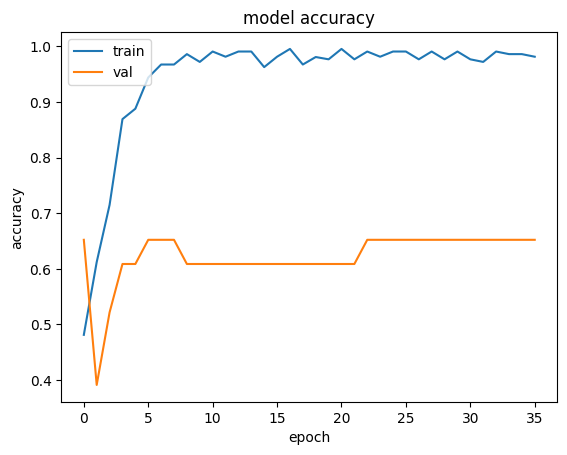

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

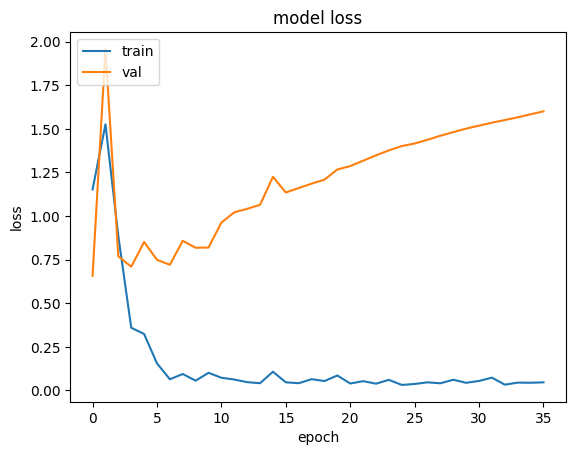

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras import models
model.load_weights(model_path)

In [ ]:
model.save(model_path)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
batch_size = 32
predictions = model.predict(val_dict, steps=3, verbose=0)

# Classification report

In [ ]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['benign', 'malignant']
#getting the true labels per image
y_true = np.argmax(val_labels, axis=1)
#getting the predicted labels per image
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)

In [ ]:
test_dict = {'age' : np.array(test_age),
                'shape' : np.array(test_shape),
                'echogenicity' : np.array(test_echogenicity),
                'posterior_features' : np.array(test_posterior_features),
                'halo' : np.array(test_halo),
                'calcifications' : np.array(test_calcifications),
                'skin_thickening' : np.array(test_skin_thickening),
                'image' : np.array(test_img_lst)
               }
batch_size = 32
predictions = model.predict(test_dict, steps=3, verbose=0)

#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['benign', 'malignant']
#getting the true labels per image
y_true = np.argmax(test_labels, axis=1)
#getting the predicted labels per image
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      benign       0.62      1.00      0.76        16
   malignant       0.00      0.00      0.00        10

    accuracy                           0.62        26
   macro avg       0.31      0.50      0.38        26
weighted avg       0.38      0.62      0.47        26



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
